In [1]:
from __future__ import division, absolute_import, print_function
import matplotlib.pyplot as plt
import numpy as np
from pyeit.mesh.meshpy.build import create
import numpy as np
import matplotlib.pyplot as plt


import pyeit.mesh as mesh
from pyeit.eit.fem import Forward
from pyeit.eit.utils import eit_scan_lines#, norm_conductivity

import pyeit.eit.jac as jac
from pyeit.eit.interp2d import sim2pts
import time
import pandas as pd

import matplotlib.gridspec as gridspec

In [2]:
def translate_to_origin(points):
    n = len(points)
    avg_x = sum(x for x, y in points) / n
    avg_y = sum(y for x, y in points) / n
    translated_points = [(x - avg_x, y - avg_y) for x, y in points]
    return translated_points

def coordinates(num_poly):
    # Read the CSV file into a DataFrame
    df = pd.read_csv('OBJ3_REC.csv')  # Replace 'coordinates3.csv' with the actual file path
    # Extract X and Y columns
    X = df.iloc[:, 1]  # Assuming the second column is X
    Y = df.iloc[:, 2]  # Assuming the third column is Y

    # Create a list of points from X and Y columns
    original_points = list(zip(X, Y))

    # Translate points to the origin
    translated_points = translate_to_origin(original_points)
    points = [[x, y] for x, y in translated_points]
    points = list(points)
    n = [np.size(points, 0)]
    return points, n

(2967,)


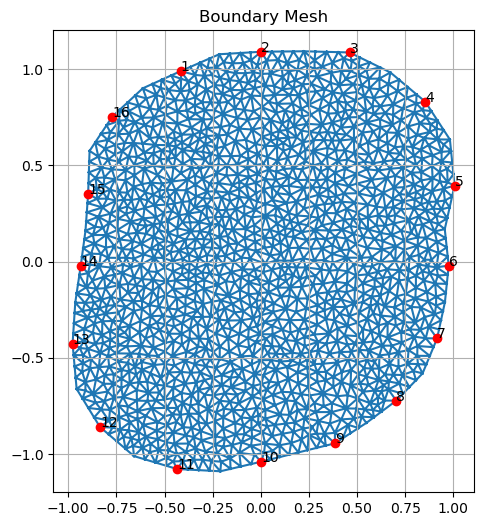

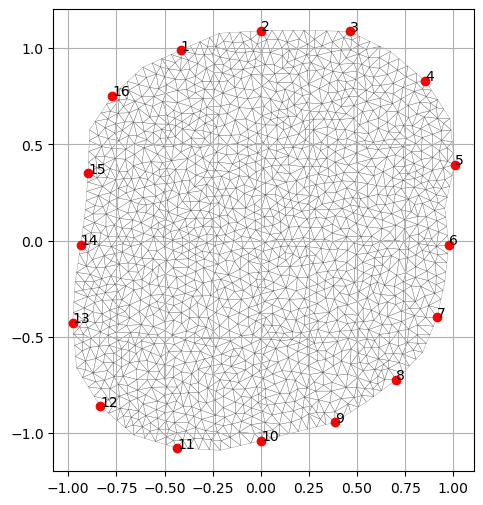

In [3]:
N_el = 16
mesh_obj, el_pos = create(16, max_area=0.002, curve=coordinates, refine=True)
pts = mesh_obj['node']
tri = mesh_obj['element']
x, y = pts[:, 0], pts[:, 1]

quasi_adjacent = False

perm = mesh_obj['perm']
print(np.shape(perm))


el_pos =  [10, 8, 6, 4, 2, 0, 30, 28, 26, 24, 22, 20, 18,16,14, 12, ]

el_pos = np.array(el_pos)
fig, ax = plt.subplots(figsize=(6, 6))
plt.triplot(pts[:, 0], pts[:, 1], tri)
ax.set_aspect('equal')
for i, e in enumerate(el_pos):
    plt.plot(pts[el_pos[i], 0], pts[el_pos[i], 1], 'ro')
    plt.annotate(str(i+1), xy=(x[e], y[e]), color='k')

plt.title("Boundary Mesh")
plt.grid()
plt.show()   

fig, ax = plt.subplots(figsize=(6, 6))


ax.tripcolor(x, y, tri, np.real(perm),
              edgecolors='k', shading='flat', alpha=0.5,
              cmap=plt.cm.Greys)
for i, e in enumerate(el_pos):
    
    plt.plot(pts[el_pos[i], 0], pts[el_pos[i], 1], 'ro')
    plt.annotate(str(i+1), xy=(x[e], y[e]), color='k')
    
#splt.axis([-0.5,0.5,-0.5,0.5])
plt.grid()
ax.set_aspect('equal')
plt.show()

In [6]:
print(np.shape(pts))
print(np.shape(tri))
print(np.shape(perm))

(1548, 2)
(2967, 3)
(2967,)


# BUAT PAPER

[7.632167 1.251583 1.7528   1.183661 1.782107]
[20.91346   6.372707  5.331786  3.095651  2.927551]


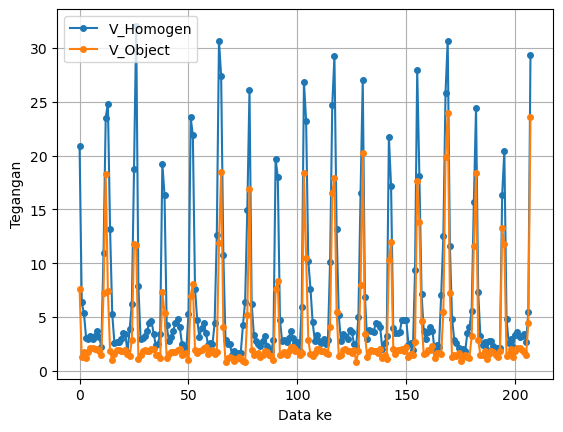

(1548,) (1548,) (2967, 3) (1548,) (2967,)


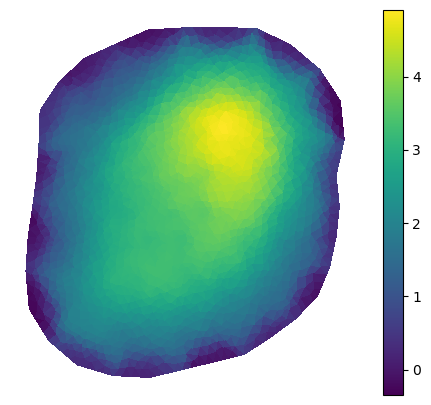

2.246990272548884


In [4]:
""" 2. FEM simulation """
el_dist, step = 1, 1
ex_mat = eit_scan_lines(N_el, el_dist)


""" 3. JAC solver """
eit = jac.JAC(mesh_obj, el_pos, ex_mat=ex_mat, step=step,
              perm=1., parser='std', jac_normalized=False)

""" 4. Initial setup """
stomachRecord = []
signalRecord = []
measNum = []
initialCount = 0
Current = 5#mA
frequency = 10000#mA

directory = './'
bgfile = 'OBJ3_HOM_1_=20000Hz'
objfile = 'OBJ3_PER2_OBJ_1m_8_=20000Hz'

data2 = pd.read_csv(directory+bgfile+'.csv')
data1 = pd.read_csv(directory+objfile+'.csv')

Z_Inclusion = np.array(data1['Z [Ohm]'])
Z_Inclusion = np.concatenate((Z_Inclusion[195:], Z_Inclusion[:195]))
print(Z_Inclusion[:5])
Z_mean = np.ones(208)
Z_mean = Z_mean*np.mean(Z_Inclusion)
Z_Homogen = np.array(data2['Z [Ohm]'])
Z_Homogen = np.concatenate((Z_Homogen[195:], Z_Homogen[:195]))
print(Z_Homogen[:5])

Zh = list(Z_Homogen)
Zi = list(Z_Inclusion)

vi = Z_Inclusion
vh = Z_Homogen
d_error = []
c_error = []

vdif = abs(vh-vi)/vh
plt.plot(vh, marker='o', markersize=4, label='V_Homogen')
plt.plot(vi, marker='o', markersize=4, label='V_Object')
plt.legend()
plt.xlabel('Data ke')
plt.ylabel('Tegangan')
plt.grid(True)
plt.show()

pVal=0.4474
lambVal=0.251
eit.setup(p=pVal, lamb=lambVal, method='kotre')
ds = eit.solve(vi, vh, normalize=True)
#th = np.min(ds) + 0.1*(np.max(ds)-np.min(ds)) #Treshold 25% dari min. 
#ds[ds>th]=th
#ds[ds>-0.102]=-0.102
ds_n = sim2pts(pts, tri, np.real(ds))
print(np.shape(x),np.shape(y),np.shape(tri),np.shape(ds_n), np.shape(ds))

# plot EIT reconstruction
fig, ax = plt.subplots(figsize=(6, 5))
# im = ax.tripcolor(x, y, tri, allDSN[m], shading='flat',cmap=plt.cm.jet, vmin=-60, vmax=20)
im = ax.tripcolor(x, y, tri, ds_n, shading='flat')
"""for i, e in enumerate(el_pos):
    ax.annotate(str(i+1), xy=(x[e], y[e]), color='r')"""
fig.colorbar(im)
ax.axis('off')
ax.set_aspect('equal')
# fig.set_size_inches(6, 4)
plt.savefig(directory+'AHOH'+objfile+'_p'+str(pVal)+'_lamb'+str(lambVal)+'.png', dpi=300)
plt.show()
print(np.mean(np.real(ds)))
#[28 30  0  2  4  6  8 10 12 14 16 18 20 22 24 26]
#[0.19501328 0.03729582 0.00646293 0.00220847 0.00317311]
#[0.19586933 0.07263219 0.03961194 0.02985668 0.03385615]

In [13]:
np.savetxt("DATA_OBJ3_OBJ_FIX.csv", Z_Inclusion, delimiter=',', fmt='%f')
np.savetxt("DATA_OBJ3_HOM_FIX.csv", Z_Homogen, delimiter=',', fmt='%f')

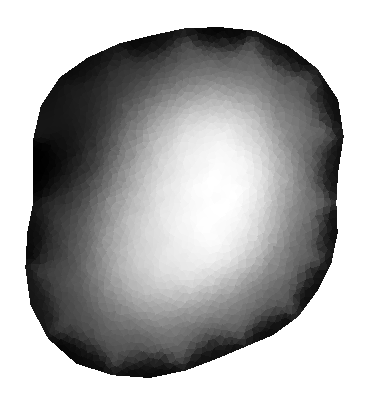

In [26]:
# NGEPLOT
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.tripcolor(x, y, tri, ds_n, shading='flat',cmap=plt.cm.gray)
ax.axis('off')
ax.set_aspect('equal')
plt.savefig(directory+'Recon1'+'.png', dpi=300)
plt.show()

C:\Users\Alfian Daffa Baihaqi\AppData\Local\Temp\ipykernel_17356\2898393035.py:21: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image1_resized = image1.resize(target_size, Image.ANTIALIAS)
C:\Users\Alfian Daffa Baihaqi\AppData\Local\Temp\ipykernel_17356\2898393035.py:22: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image2_resized = image2.resize(target_size, Image.ANTIALIAS)


SSIM score: 0.7930113526403222


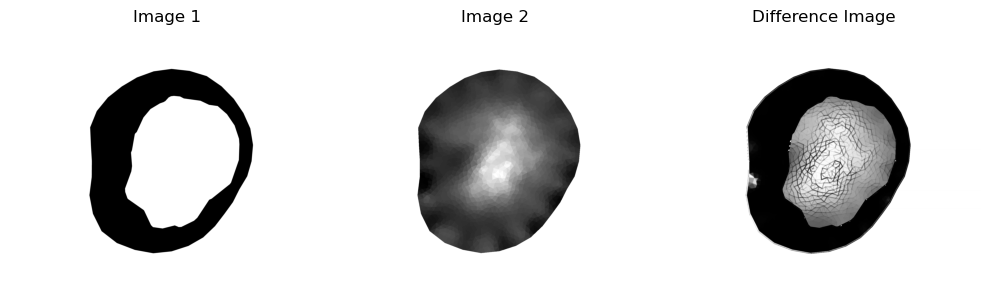

In [15]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage import io
import matplotlib.pyplot as plt

from skimage.metrics import structural_similarity as ssim
import numpy as np
from PIL import Image

# Load the images
image1 = Image.open('GT_OBJ2-01.png')
image2 = Image.open('Recon1.png')

image1 = image1.convert('L')
image2 = image2.convert('L')

# Determine the target size
target_size = (max(image1.width, image2.width), max(image1.height, image2.height))

# Resize the images
image1_resized = image1.resize(target_size, Image.ANTIALIAS)
image2_resized = image2.resize(target_size, Image.ANTIALIAS)

# Convert images to numpy arrays
image1_array = np.array(image1_resized)
image2_array = np.array(image2_resized)

# Calculate SSIM score
score, diff = ssim(image2_array, image1_array, full=True)

# Convert the difference image to the range [0, 255]
diff = (diff * 255).astype(np.uint8)

# Display the images
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
ax = axes.ravel()

ax[0].imshow(image1_array, cmap=plt.cm.gray)
ax[0].set_title('Image 1')

ax[1].imshow(image2_array, cmap=plt.cm.gray)
ax[1].set_title('Image 2')

ax[2].imshow(diff, cmap=plt.cm.gray)
ax[2].set_title('Difference Image')

for a in ax:
    a.axis('off')

# Print the SSIM score
print(f"SSIM score: {score}")

# Save the difference image
io.imsave('diff_image.jpg', diff)

# Display the figure
plt.tight_layout()
plt.show()

[1 0 1 ... 0 0 0]


E:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


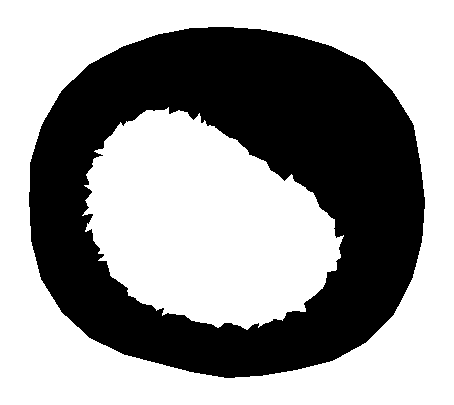

In [41]:
from sklearn.cluster import KMeans
import numpy as np


# Fit the K-Means model to the data
kmeans = KMeans(n_clusters=2)
kmeans.fit(ds.reshape(-1, 1))

# Get the cluster assignments for each data point
clusters = kmeans.predict(ds.reshape(-1, 1))

# Print the cluster assignments
print(clusters)
# Plot EIT reconstruction with clustering
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.tripcolor(x, y, tri, clusters, shading='flat', cmap=plt.cm.binary_r)
ax.axis('off')
ax.set_aspect('equal')
plt.savefig(directory+'Ahh1'+objfile+'_p'+str(pVal)+'_lamb'+str(lambVal)+'.png', dpi=96)
plt.show()

# Loop and Get IoU

[7.632167 1.251583 1.7528   1.183661 1.782107]
[20.91346   6.372707  5.331786  3.095651  2.927551]


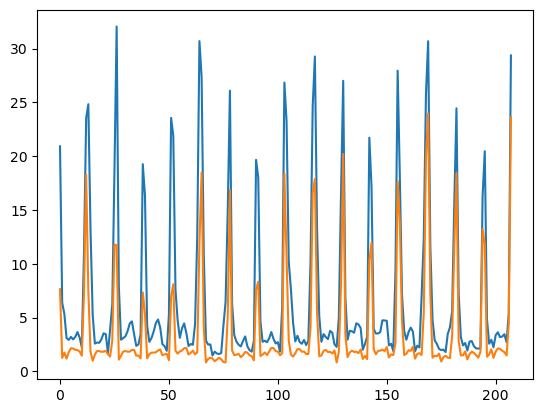

E:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

E:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

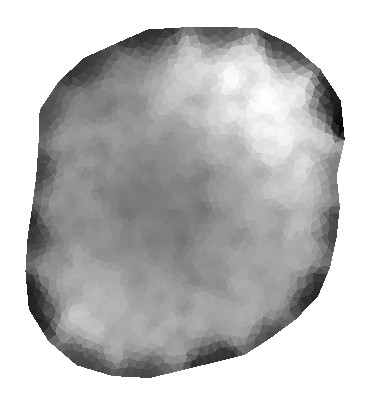

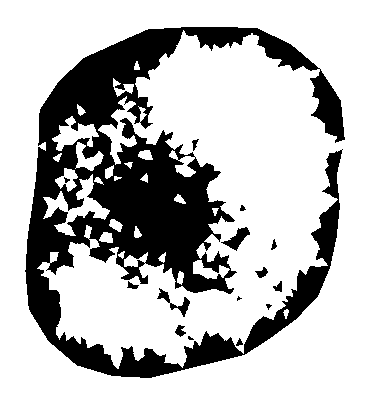

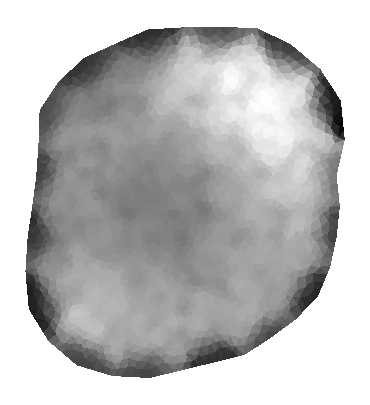

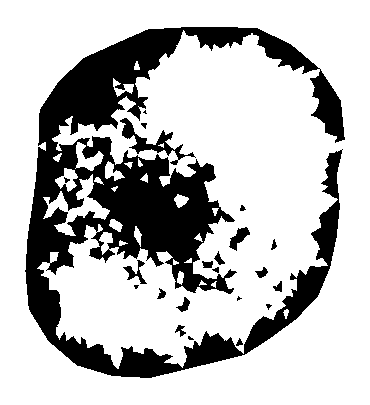

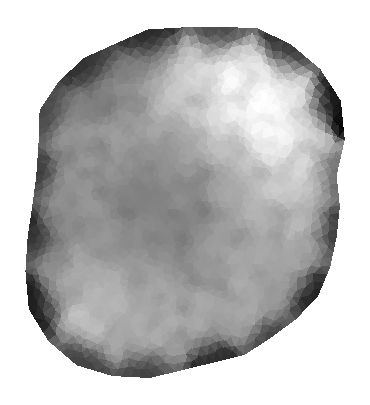

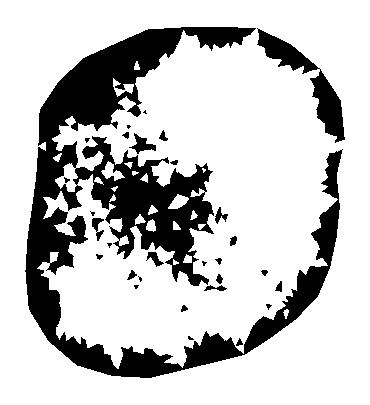

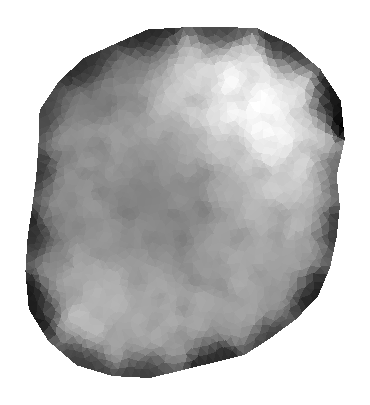

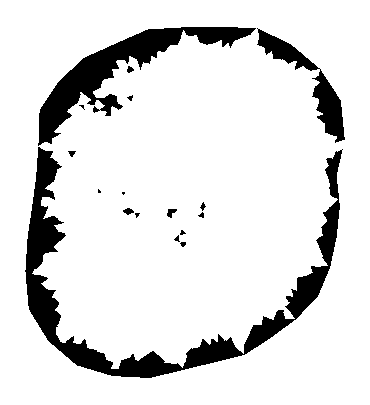

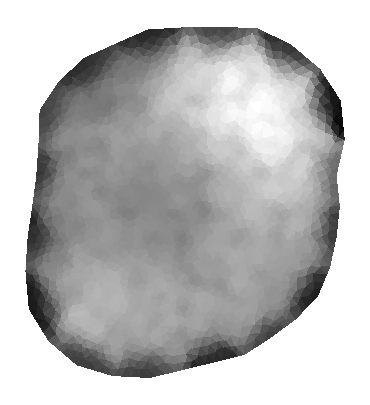

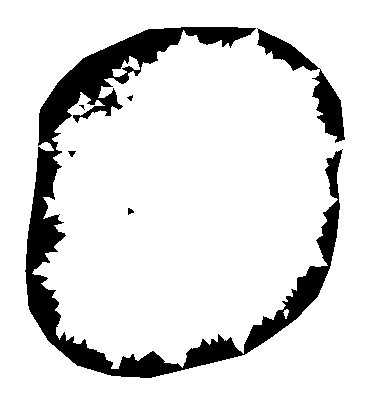

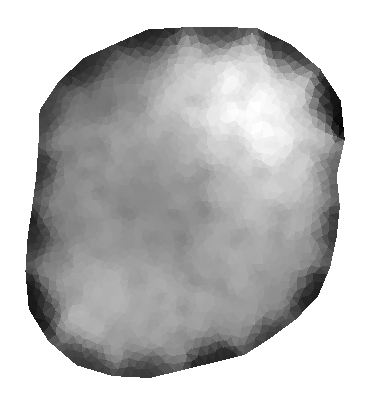

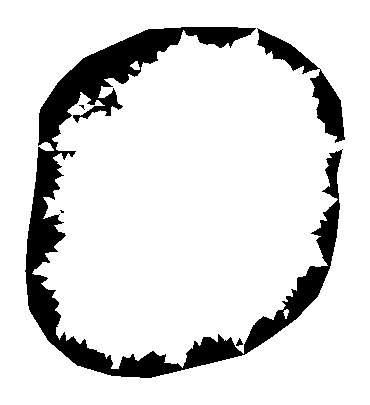

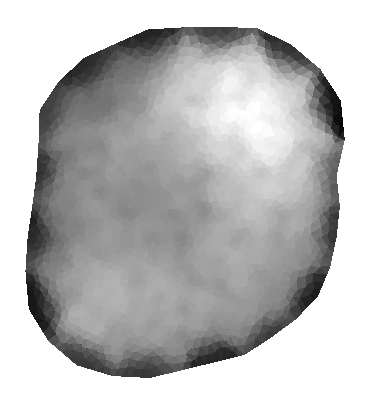

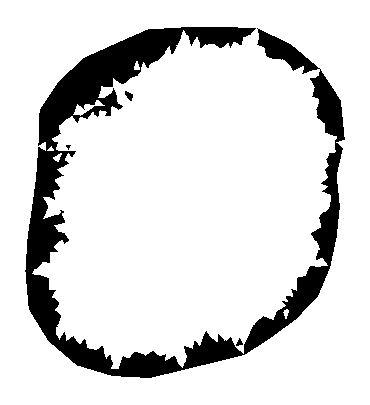

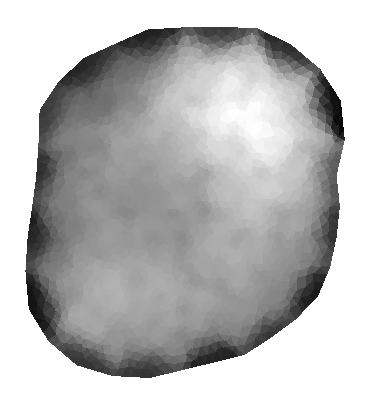

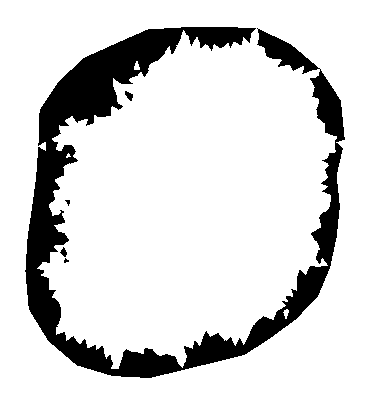

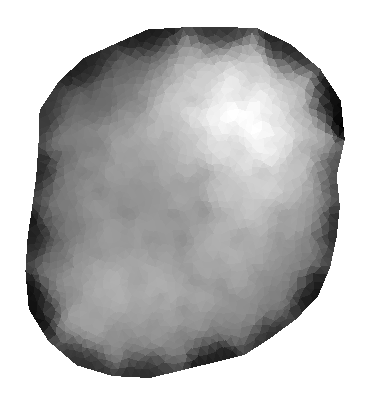

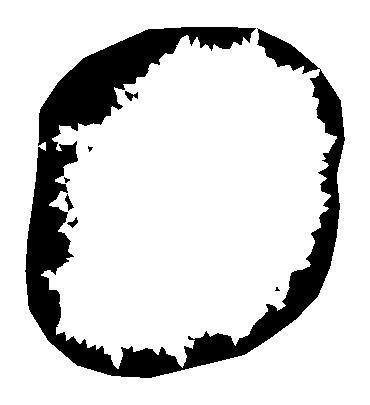

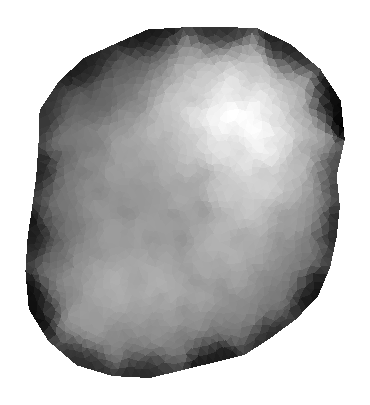

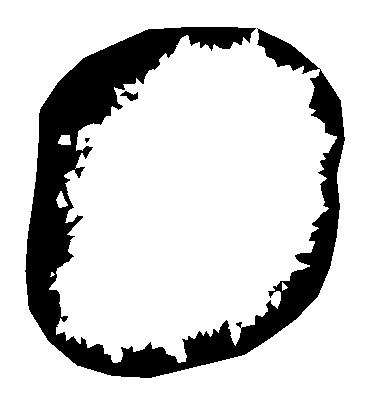

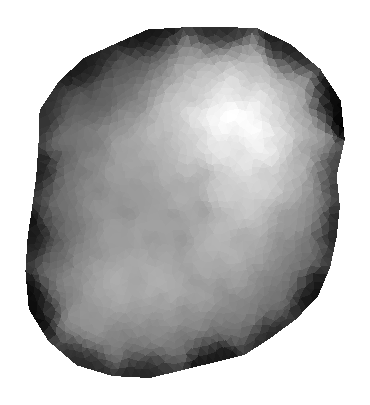

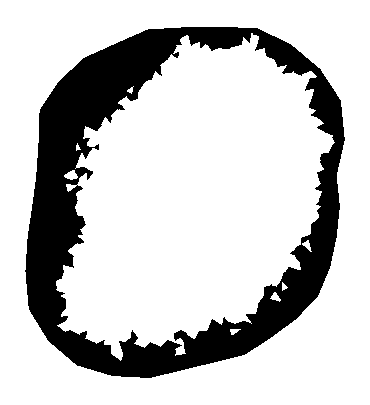

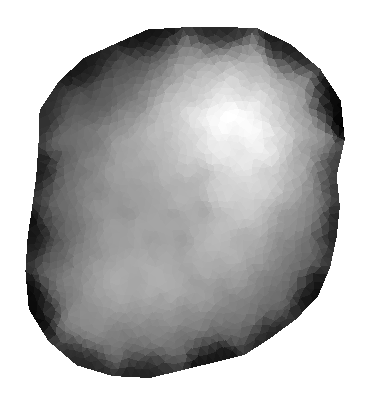

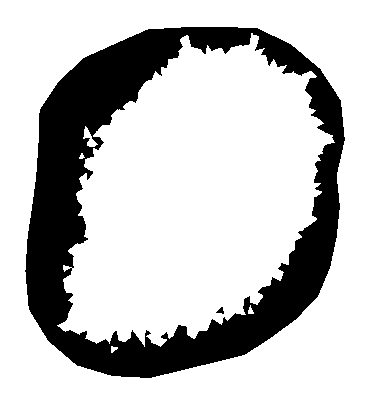

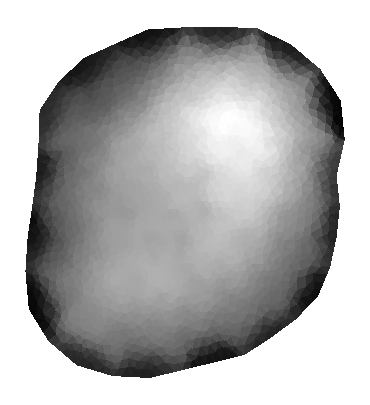

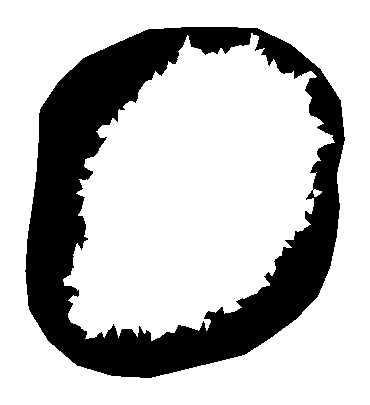

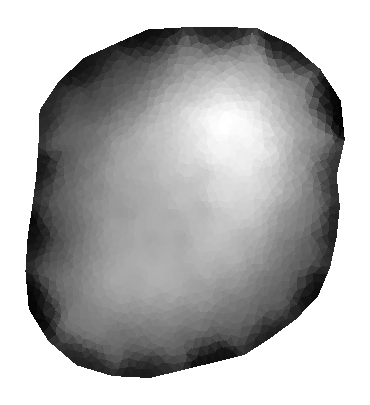

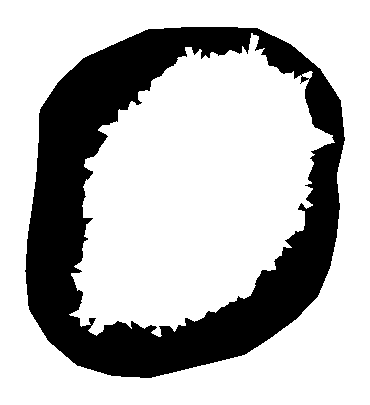

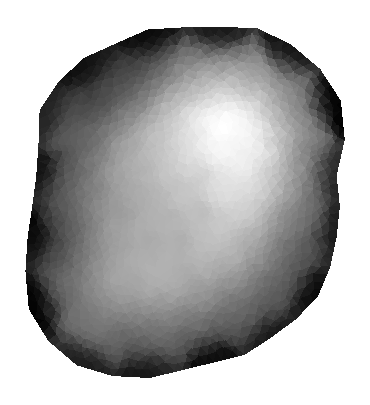

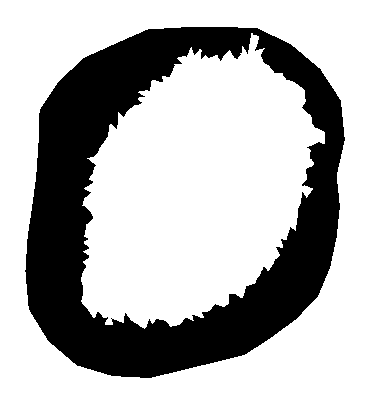

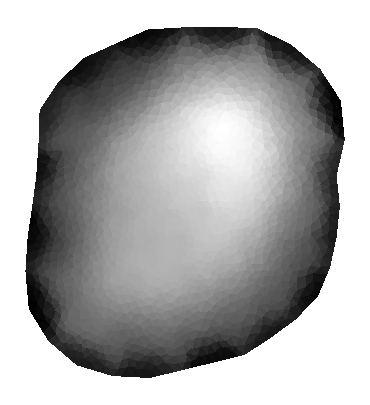

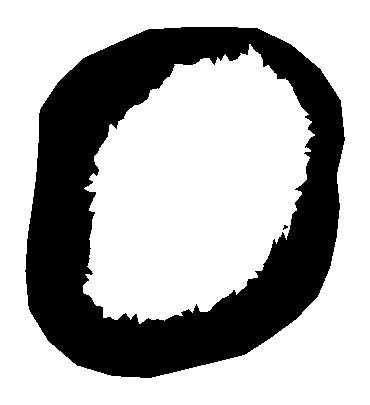

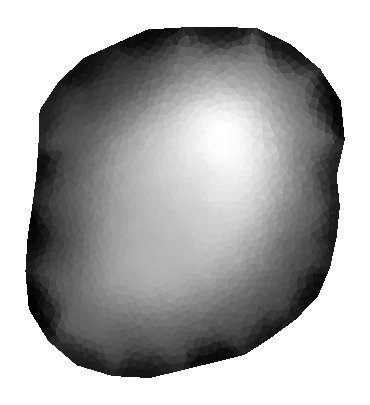

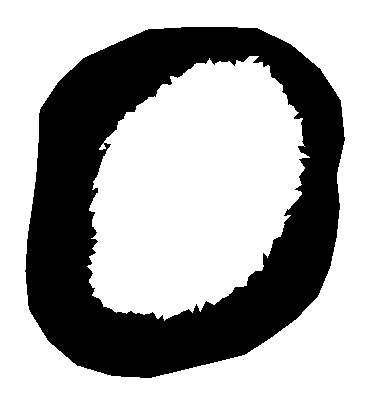

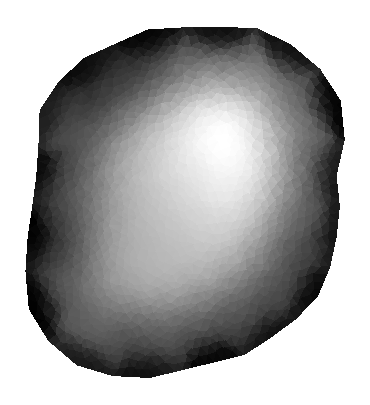

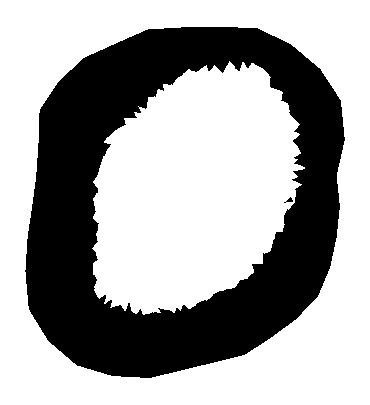

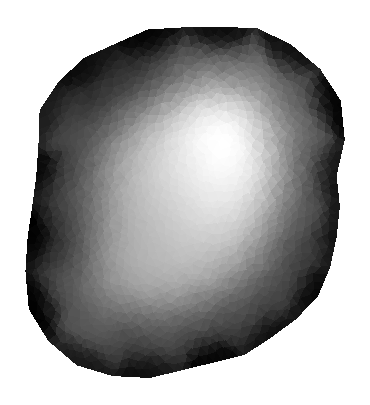

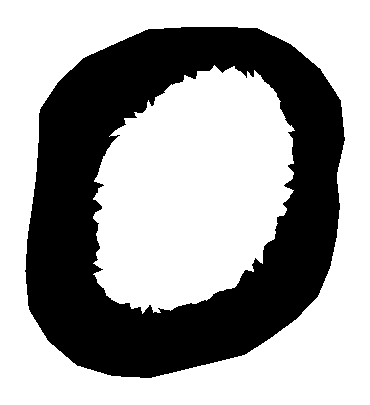

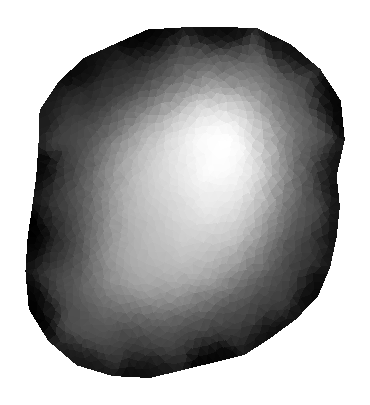

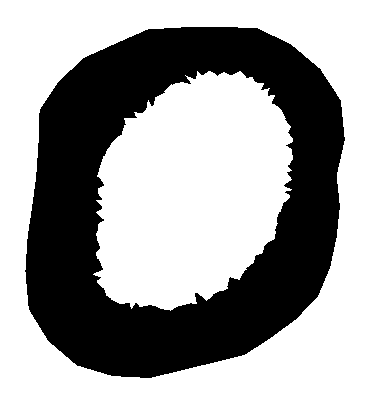

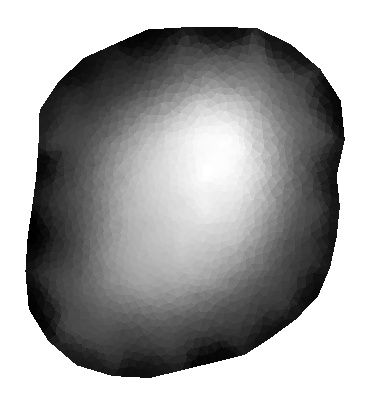

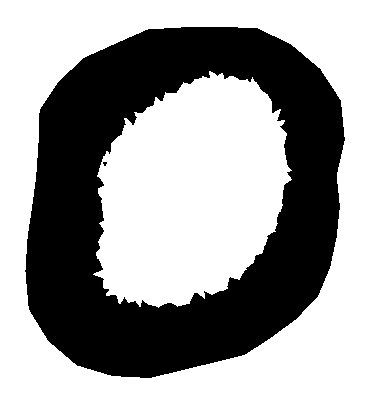

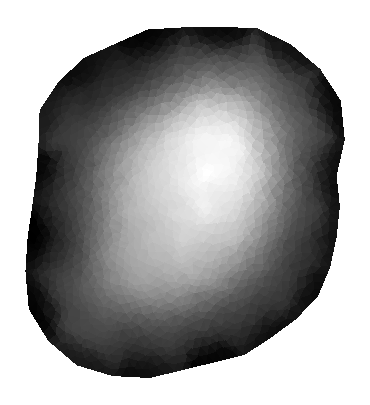

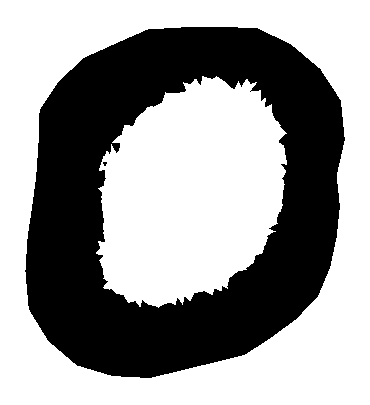

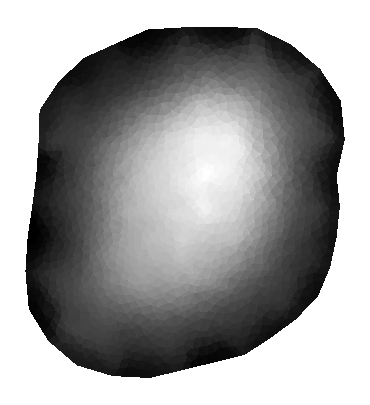

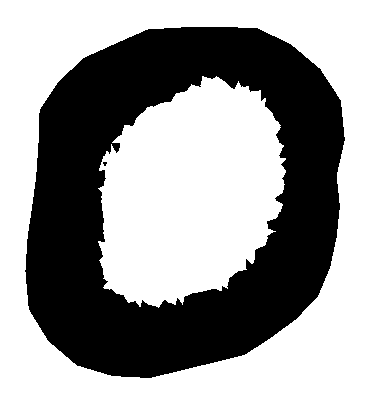

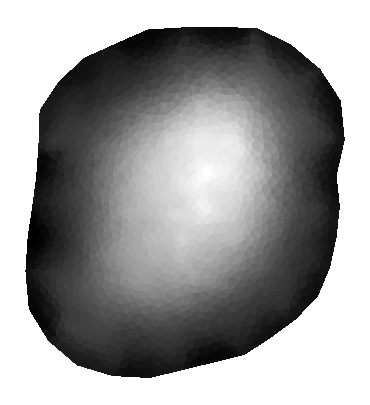

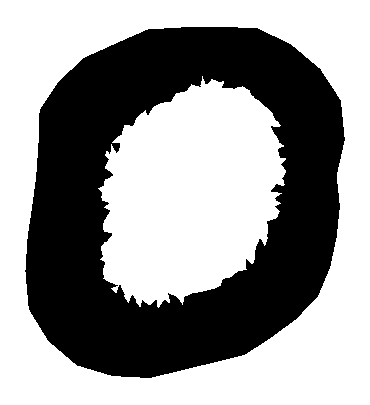

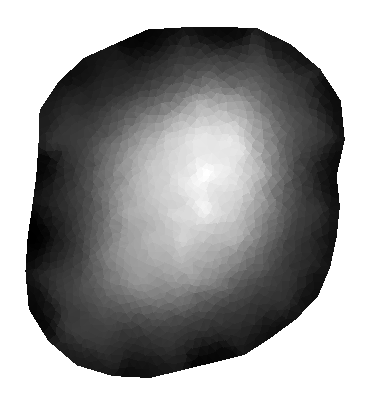

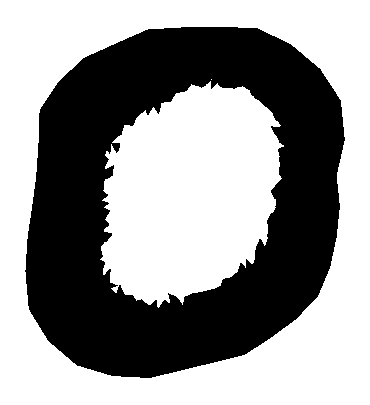

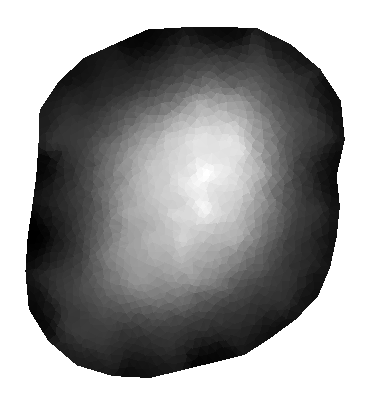

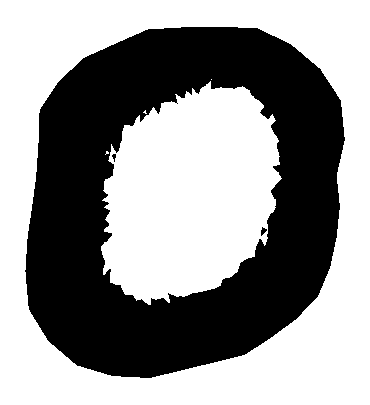

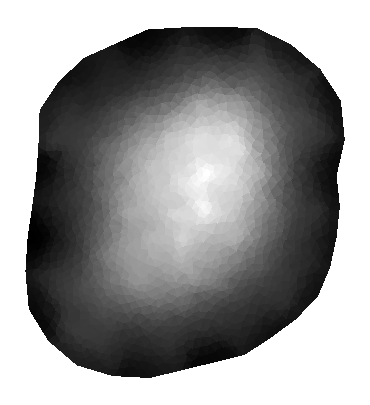

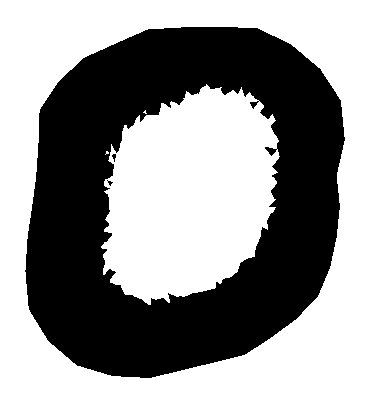

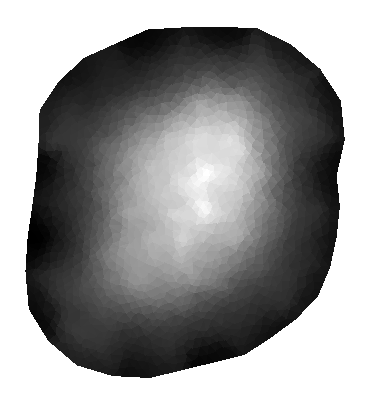

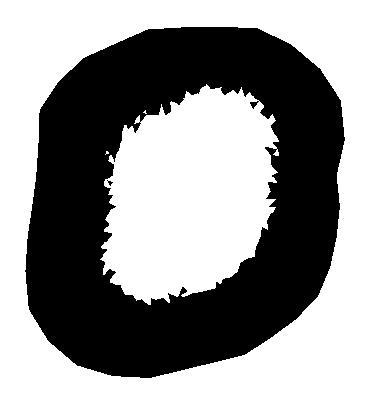

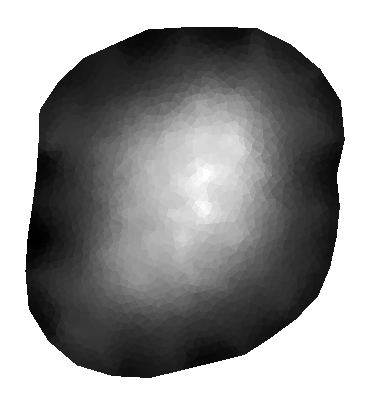

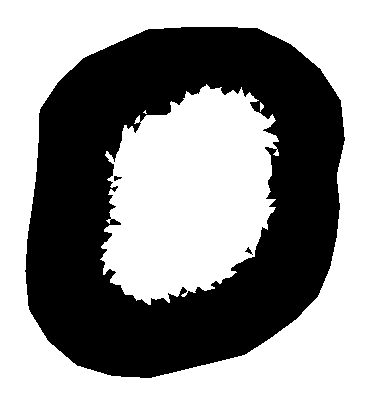

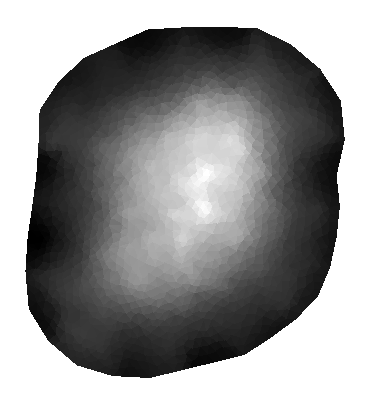

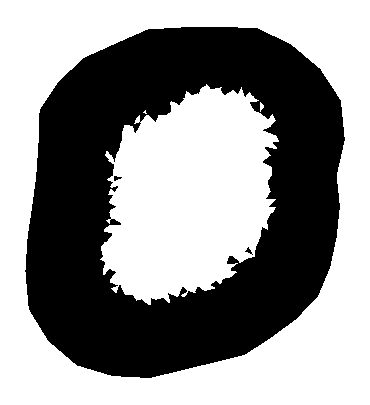

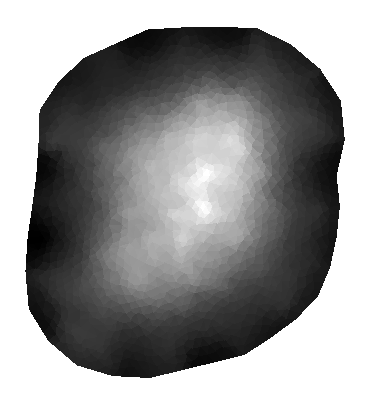

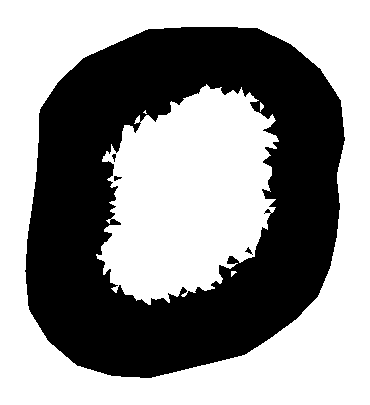

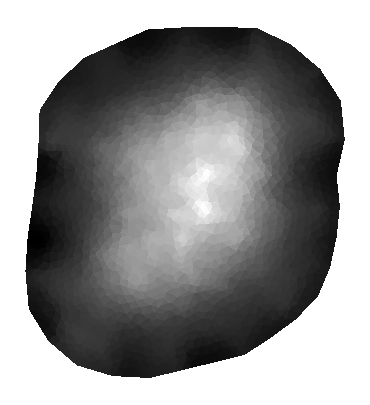

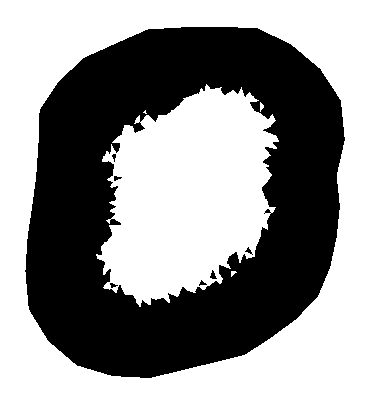

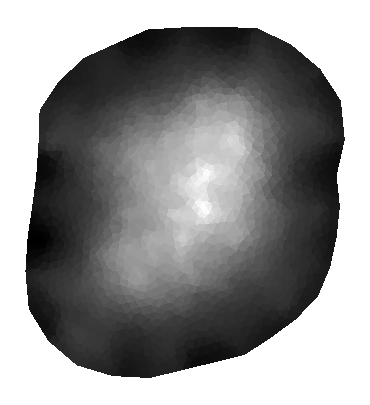

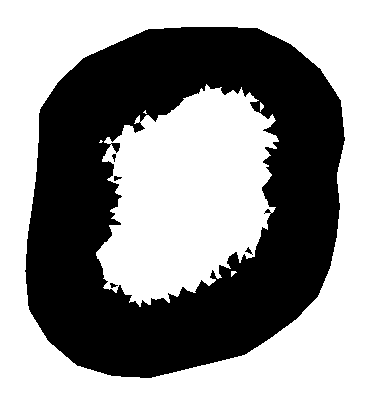

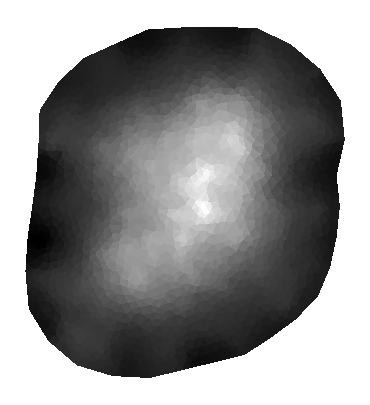

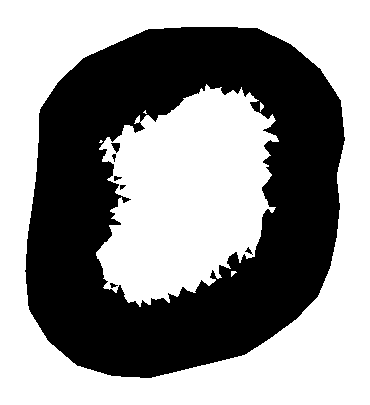

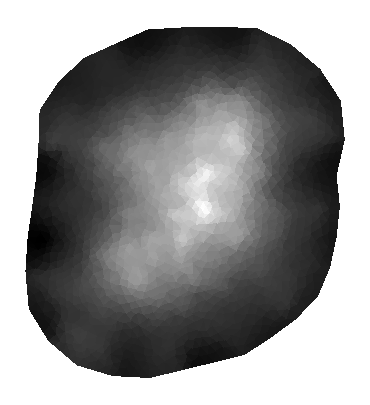

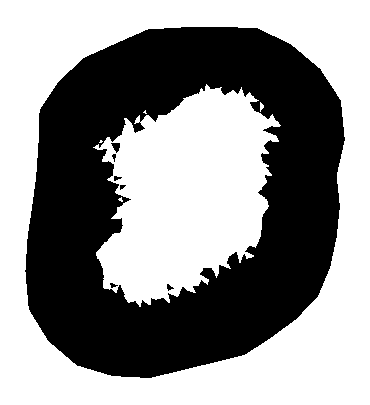

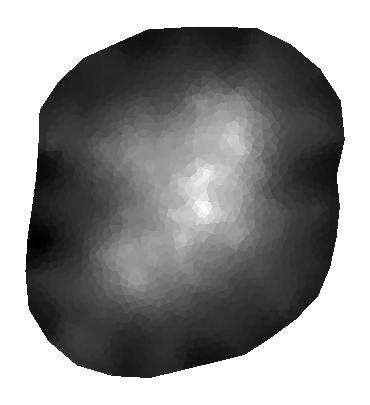

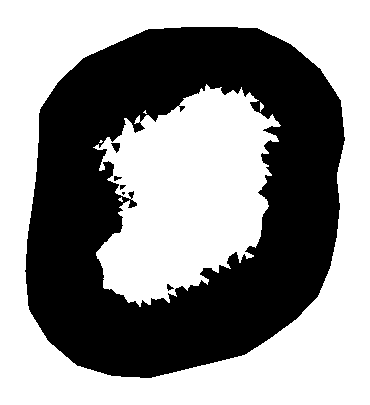

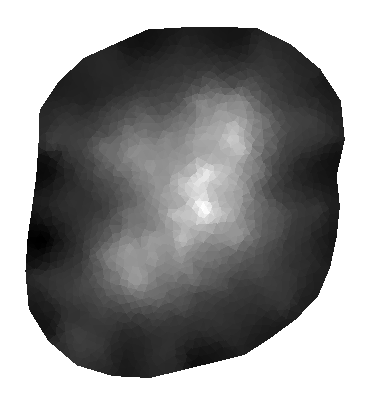

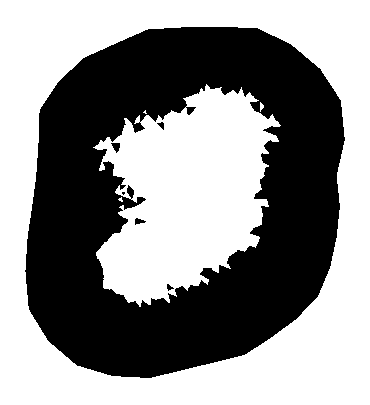

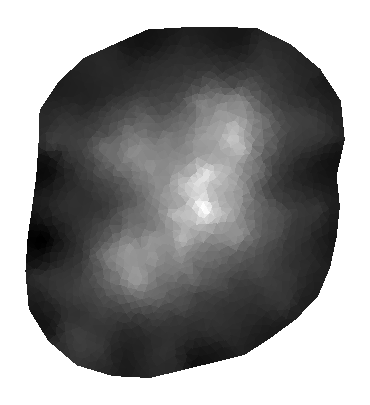

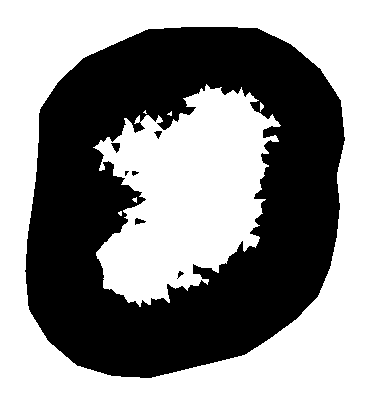

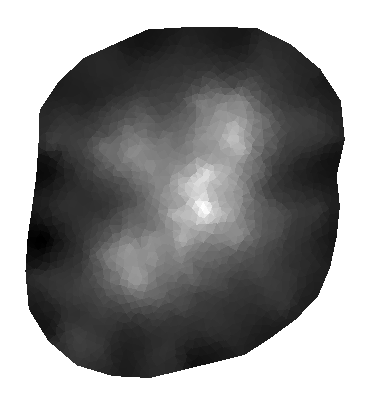

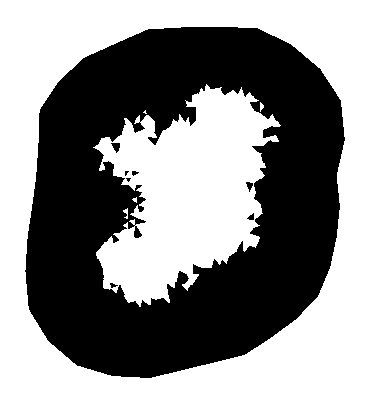

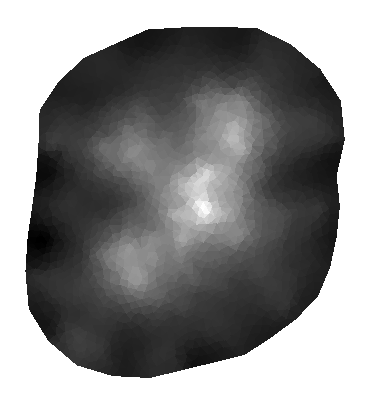

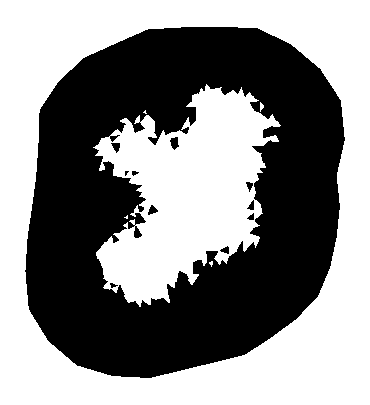

In [8]:
from sklearn.cluster import KMeans
import numpy as np
from PIL import Image
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score, confusion_matrix
from skimage.metrics import structural_similarity as ssim


""" 2. FEM simulation """
el_dist, step = 1, 1
ex_mat = eit_scan_lines(N_el, el_dist)


""" 3. JAC solver """
eit = jac.JAC(mesh_obj, el_pos, ex_mat=ex_mat, step=step,
              perm=1., parser='std', jac_normalized=False)

""" 4. Initial setup """

directory = './'
bgfile = 'OBJ3_HOM_1_=20000Hz'
objfile = 'OBJ3_PER2_OBJ_1m_8_=20000Hz'

data2 = pd.read_csv(directory+bgfile+'.csv')
data1 = pd.read_csv(directory+objfile+'.csv')

Z_Inclusion = np.array(data1['Z [Ohm]'])
Z_Inclusion = np.concatenate((Z_Inclusion[195:], Z_Inclusion[:195]))
print(Z_Inclusion[:5])
Z_mean = np.ones(208)
Z_mean = Z_mean*np.mean(Z_Inclusion)
Z_Homogen = np.array(data2['Z [Ohm]'])
Z_Homogen = np.concatenate((Z_Homogen[195:], Z_Homogen[:195]))
print(Z_Homogen[:5])

Zh = list(Z_Homogen)
Zi = list(Z_Inclusion)

vi = Z_Inclusion
vh = Z_Homogen
d_error = []
c_error = []

vdif = abs(vh-vi)/vh
plt.plot(vh)
plt.plot(vi)
plt.show()

pVal=np.linspace(0.25, 0.8, 40)
lambVal = 0.25
methodVal = 'kotre'


# Iterate over each p value
for m, p_Val in enumerate(pVal):
    npval = "{:.2f}".format(pVal[m]) 
    # Setup
    eit.setup(p=p_Val, lamb=lambVal, method=methodVal)    
    # Solve
    ds = eit.solve(vi, vh, normalize=True)
    #th = np.min(ds) + 0.25*(np.max(ds)-np.min(ds)) #Treshold 25% dari min. 
    #ds[ds>th]=th
    ds_n = sim2pts(pts, tri, np.real(ds))
    
    # NGEPLOT
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.tripcolor(x, y, tri, ds_n, shading='flat', cmap=plt.cm.gray)
    ax.axis('off')
    ax.set_aspect('equal')
    plt.savefig(directory+'OUTOBJ3_REC_EXP/'+'ImageRecons'+str(npval)+'.png', dpi=96)
    #plt.show()

    # Fit the K-Means model to the data
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(ds.reshape(-1, 1))
    clusters = kmeans.predict(ds.reshape(-1, 1))

    # Remapping clusters based on their means
    if np.mean(ds[clusters == 0]) < np.mean(ds[clusters == 1]):
        # Swap labels
        clusters = np.where(clusters == 0, 1, 0)

    norm = plt.Normalize(0, 1)
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.tripcolor(x, y, tri, clusters, shading='flat', cmap=plt.cm.binary, norm=norm)
    ax.axis('off')
    ax.set_aspect('equal')
    plt.savefig(directory+'OUTOBJ3_REC_EXP/'+'ImageClustering'+str(npval)+'.png', dpi=96)
    #plt.show()

In [16]:
pVal=np.linspace(0.25, 0.8, 40)
def calculate_iou(image1, image2):
    # Ensure both images are the same size
    assert image1.shape == image2.shape, "Images must have the same dimensions for IoU calculation."

    intersection = np.logical_and(image1 == image2, image1 > 0)  # Assuming nonzero pixels are "objects"
    union = np.logical_or(image1 > 0, image2 > 0)

    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_rmse(img1, img2):
    return np.sqrt(np.mean((img1 - img2) ** 2))

def calculate_mae(img1, img2):
    return (np.mean(np.abs(img1 - img2)))

def calculate_iou(image1, image2):
    # Ensure both images are the same size
    assert image1.shape == image2.shape, "Images must have the same dimensions for IoU calculation."

    intersection = np.logical_and(image1 == image2, image1 > 0)  # Assuming nonzero pixels are "objects"
    union = np.logical_or(image1 > 0, image2 > 0)

    iou = np.sum(intersection) / np.sum(union)
    return iou
def compute_accuracy(ground_truth, prediction):
    # Calculate total number of pixels
    total_pixels = ground_truth.size
    print(total_pixels)

    # Calculate correct predictions (true positives + true negatives)
    correct_predictions = np.sum(ground_truth == prediction)

    # Calculate accuracy
    accuracy = correct_predictions / total_pixels
    return accuracy
def compute_f1_score(ground_truth, prediction):
    # Ensure images have the same dimensions
    assert ground_truth.shape == prediction.shape, "Images must have the same dimensions."
    ground_truth = (np.array(ground_truth) > 128).astype(int)  # Converts 255 to 1, keeps 0 as 0
    prediction = (np.array(prediction) > 128).astype(int)
    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = np.sum((prediction == 1) & (ground_truth == 1))
    FP = np.sum((prediction == 1) & (ground_truth == 0))
    FN = np.sum((prediction == 0) & (ground_truth == 1))

    # Calculate Precision, Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

def relative_error_percentage(img1, img2):
    # Pastikan kedua gambar memiliki ukuran yang sama
    if img1.shape != img2.shape:
        raise ValueError("Kedua gambar harus memiliki ukuran yang sama.")
    # Menghitung perbedaan absolut
    abs_diff = np.abs(img1 - img2)
        # Menghindari pembagian dengan nol
    with np.errstate(divide='ignore', invalid='ignore'):
        relative_error = np.where(img1 != 0, abs_diff / img1, np.nan)
    # Mengabaikan nilai-nilai nan dalam perhitungan rata-rata
    mean_relative_error = np.nanmean(relative_error)
    # Mengkonversi ke persentase
    relative_error_percentage = mean_relative_error * 100
    return relative_error_percentage

allIoU = []
allAcc = []
allIoU2 = []
allDc = []
allPrec = []
allRec = []
allSSIM = []
allRMSE = []
allPerError = []

for m, p_Val in enumerate(pVal):
    npval = "{:.2f}".format(pVal[m]) 
    # Load the images
    image1 = Image.open('GT_REC_OBJ3_GT.png')
    image2 = Image.open('OUTOBJ3_REC_EXP/ImageClustering'+str(npval)+'.png')
    image3 = Image.open('OUTOBJ3_REC_EXP/ImageRecons'+str(npval)+'.png')

    image1 = image1.convert('L')
    image2 = image2.convert('L')
    image3 = image3.convert('L')

    # Determine the target size
    target_size = (max(image1.width, image2.width), max(image1.height, image2.height))

    # Resize the images
    image1_resized = image1.resize(target_size, Image.ANTIALIAS)
    image2_resized = image2.resize(target_size, Image.ANTIALIAS)
    image3_resized = image3.resize(target_size, Image.ANTIALIAS)
    

    # Convert images to numpy arrays
    image1_array = np.array(image1_resized)
    image2_array = np.array(image2_resized)
    image3_array = np.array(image3_resized)
    
    #print(np.shape(image1_array))
    #print(np.shape(image2_array))
    #print(np.shape(image3_array))
    # Calculate SSIM
    ssim_index = ssim(image1_array, image3_array, data_range=image1_array.max() - image3_array.min())
    #print("SSIM:", ssim_index)
    allSSIM.append(ssim_index)
    # Calculate IoU
    iou_score = calculate_iou(image1_array, image3_array)
    allIoU.append(iou_score)
    #print("The IoU score is:", iou_score)
    # Calculate Accuracy
    accuracy_score = compute_accuracy(image1_array, image2_array)
    #print("Accuracy:", accuracy_score)
    allAcc.append(accuracy_score)
    f1_score = compute_f1_score(image1_array, image3_array)
    #print("F1 Score:", f1_score)
    allDc.append(f1_score)
    rmse = calculate_mae(image1_array, image3_array)
    #print("RMSE:", rmse)
    allRMSE.append(rmse)
    
    error_percentage = relative_error_percentage(image1_array, image3_array)
    allPerError.append(error_percentage)

C:\Users\Alfian Daffa Baihaqi\AppData\Local\Temp\ipykernel_12112\2040437192.py:96: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image1_resized = image1.resize(target_size, Image.ANTIALIAS)
C:\Users\Alfian Daffa Baihaqi\AppData\Local\Temp\ipykernel_12112\2040437192.py:97: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image2_resized = image2.resize(target_size, Image.ANTIALIAS)
C:\Users\Alfian Daffa Baihaqi\AppData\Local\Temp\ipykernel_12112\2040437192.py:98: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image3_resized = image3.resize(target_size, Image.ANTIALIAS)


2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301
2703301


In [12]:
np.savetxt("RMSE_OBJ3_REC_EXP.csv", allRMSE, delimiter=',', fmt='%f')
np.savetxt("MAPE_OBJ3_REC_EXP.csv", allPerError, delimiter=',', fmt='%f')
np.savetxt("ACC_OBJ3_REC_EXP.csv", allAcc, delimiter=',', fmt='%f')

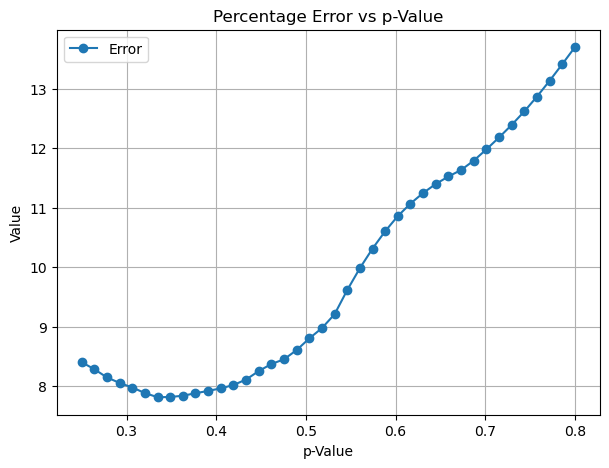

MAPE: 7.811127940901088
pVal: 0.33461538461538465
MAPE: 8.251209275421935


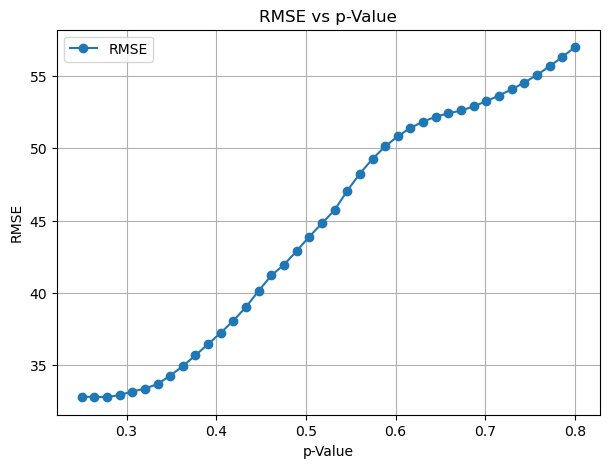

RMSE: 32.76440174438584
pVal: 0.2782051282051282
MAE: 40.1373191516594


In [19]:
pVal=np.linspace(0.25, 0.8, 40)
# RELATIVE ERROR
plt.figure(figsize=(7, 5))  # Set the figure size
plt.plot(pVal, allPerError, label='Error', marker='o')  # Plot Accuracy
#plt.plot(pVal, allSSIM, label='SSIM', marker='x')  # Plot SSIM
plt.title('Percentage Error vs p-Value')  # Title of the plot
plt.xlabel('p-Value')  # Label for the x-axis
plt.ylabel('Value')  # Label for the y-axis
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()
max_index = np.argmin(allPerError)
# Retrieve the highest IoU value
lowest_Error = allPerError[max_index]
# Retrieve the corresponding pVal
corresponding_pVal = pVal[max_index]
print("MAPE:", lowest_Error)
print("pVal:", corresponding_pVal)


target_pVal = 0.44743589743589746
# Find the index of the closest pVal
index = np.argmin(np.abs(pVal - target_pVal))
# Retrieve the corresponding allPerError value
corresponding_allPerError = allPerError[index]
# Print the result
print("MAPE:", corresponding_allPerError)

plt.figure(figsize=(7, 5))  # Set the figure size
plt.plot(pVal, allRMSE, label='RMSE', marker='o')  # Plot Accuracy
#plt.plot(pVal, allSSIM, label='SSIM', marker='x')  # Plot SSIM
plt.title('RMSE vs p-Value')  # Title of the plot
plt.xlabel('p-Value')  # Label for the x-axis
plt.ylabel('RMSE')  # Label for the y-axis
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()

max_index = np.argmin(allRMSE)
# Retrieve the highest IoU value
lowest_Error = allRMSE[max_index]
# Retrieve the corresponding pVal
corresponding_pVal = pVal[max_index]
print("RMSE:", lowest_Error)
print("pVal:", corresponding_pVal)

# Find the index of the closest pVal
index = np.argmin(np.abs(pVal - target_pVal))
# Retrieve the corresponding allPerError value
corresponding_allRMSE = allRMSE[index]
# Print the result
print("MAE:", corresponding_allRMSE)

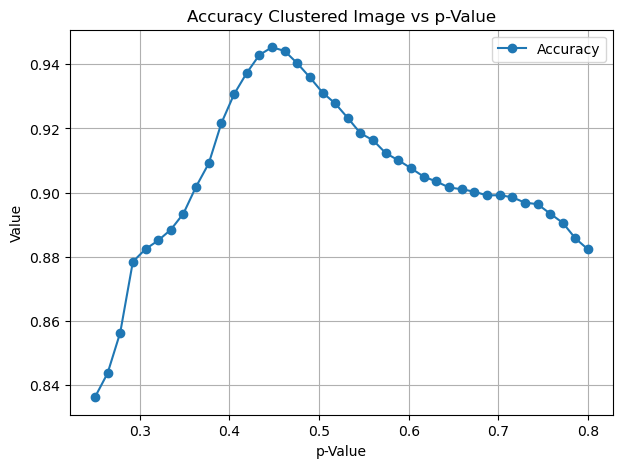

Acc: 0.9453072373368707
pVal: 0.44743589743589746


In [10]:
plt.figure(figsize=(7, 5))  # Set the figure size
plt.plot(pVal, allAcc, label='Accuracy', marker='o')  # Plot Accuracy
#plt.plot(pVal, allSSIM, label='SSIM', marker='x')  # Plot SSIM
plt.title('Accuracy Clustered Image vs p-Value')  # Title of the plot
plt.xlabel('p-Value')  # Label for the x-axis
plt.ylabel('Value')  # Label for the y-axis
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()
max_index = np.argmax(allAcc)
# Retrieve the highest IoU value
lowest_Error = allAcc[max_index]
# Retrieve the corresponding pVal
corresponding_pVal = pVal[max_index]
print("Acc:", lowest_Error)
print("pVal:", corresponding_pVal)

In [45]:
np.savetxt("RMSE3.csv", allRMSE, delimiter=',', fmt='%f')
np.savetxt("ACC3.csv", allAcc, delimiter=',', fmt='%f')

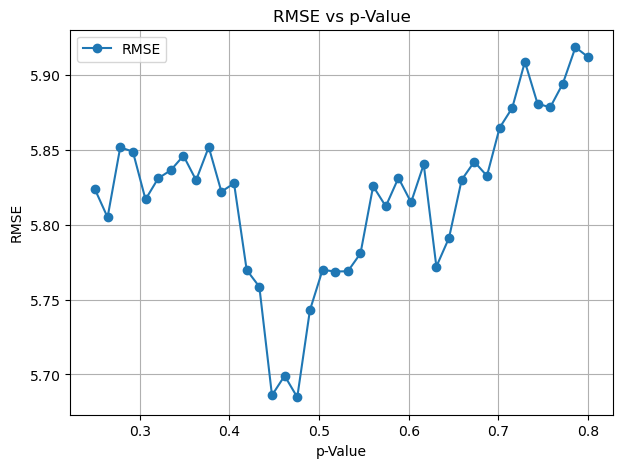

In [22]:
plt.figure(figsize=(7, 5))  # Set the figure size
plt.plot(pVal, allRMSE, label='RMSE', marker='o')  # Plot Accuracy
#plt.plot(pVal, allSSIM, label='SSIM', marker='x')  # Plot SSIM
plt.title('RMSE vs p-Value')  # Title of the plot
plt.xlabel('p-Value')  # Label for the x-axis
plt.ylabel('RMSE')  # Label for the y-axis
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()

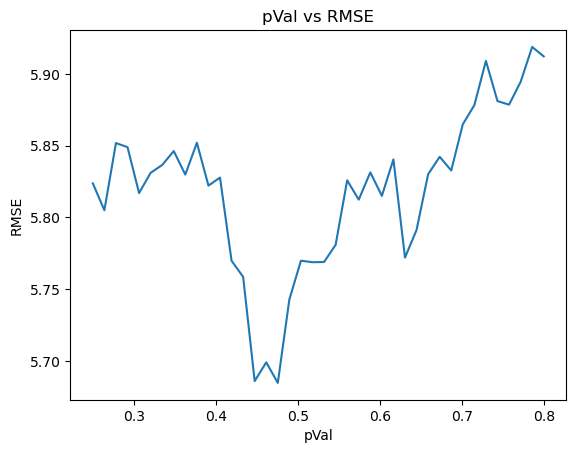

The lowest RMSE is: 5.6847608829480505
The corresponding pVal is: 0.47564102564102567


In [23]:
plt.plot(pVal, allRMSE)
plt.title('pVal vs RMSE')  # Title of the plot
plt.xlabel('pVal')  # Label for the x axis
plt.ylabel('RMSE')  # Label for the y axis
plt.show()  # Display the plot
max_index = np.argmin(allRMSE)
# Retrieve the highest IoU value
highest_RMSE = allRMSE[max_index]
# Retrieve the corresponding pVal
corresponding_pVal = pVal[max_index]
print("The lowest RMSE is:", highest_RMSE)
print("The corresponding pVal is:", corresponding_pVal)

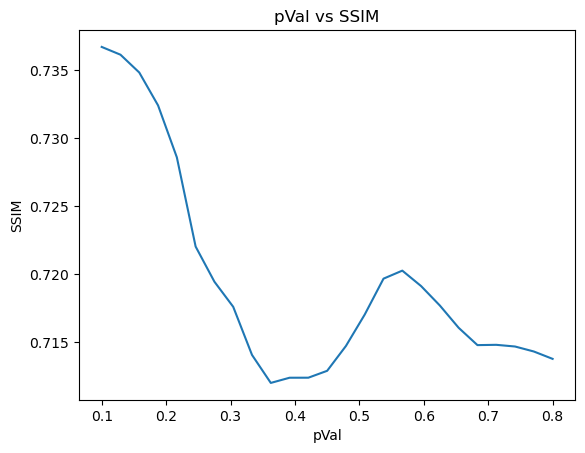

The highest SSIM is: 0.7367204418339488
The corresponding pVal is: 0.1


In [29]:
plt.plot(pVal, allSSIM)
plt.title('pVal vs SSIM')  # Title of the plot
plt.xlabel('pVal')  # Label for the x axis
plt.ylabel('SSIM')  # Label for the y axis
plt.show()  # Display the plot
max_index = np.argmax(allSSIM)
# Retrieve the highest IoU value
highest_SSIM = allSSIM[max_index]
# Retrieve the corresponding pVal
corresponding_pVal = pVal[max_index]
print("The highest SSIM is:", highest_SSIM)
print("The corresponding pVal is:", corresponding_pVal)

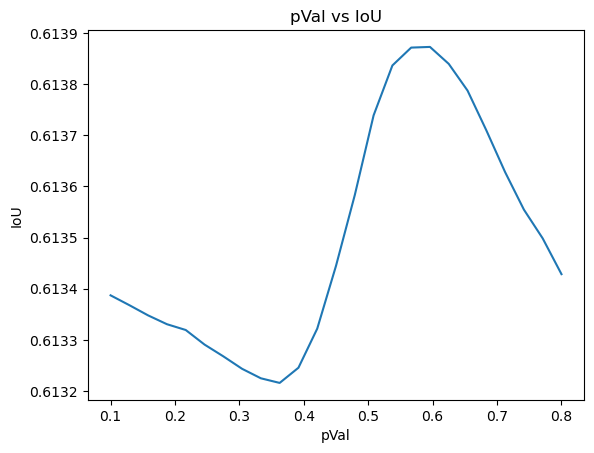

The highest IoU is: 0.6138730214902631
The corresponding pVal is: 0.5958333333333334


In [31]:
plt.plot(pVal, allIoU)
plt.title('pVal vs IoU')  # Title of the plot
plt.xlabel('pVal')  # Label for the x axis
plt.ylabel('IoU')  # Label for the y axis
plt.show()  # Display the plot
max_index = np.argmax(allIoU)
# Retrieve the highest IoU value
highest_IoU = allIoU[max_index]
# Retrieve the corresponding pVal
corresponding_pVal = pVal[max_index]
print("The highest IoU is:", highest_IoU)
print("The corresponding pVal is:", corresponding_pVal)

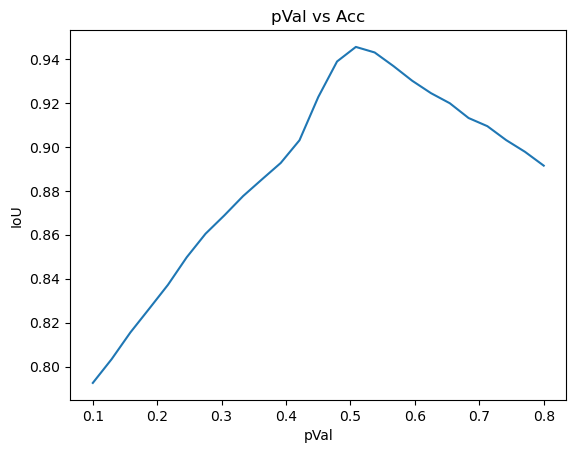

The highest Acc is: 0.9454848148148148
The corresponding pVal is: 0.5083333333333334


In [34]:
plt.plot(pVal, allAcc)
plt.title('pVal vs Acc')  # Title of the plot
plt.xlabel('pVal')  # Label for the x axis
plt.ylabel('IoU')  # Label for the y axis
plt.show()  # Display the plot
max_index = np.argmax(allAcc)

# Retrieve the highest IoU value
highest_Acc = allAcc[max_index]

# Retrieve the corresponding pVal
corresponding_pVal = pVal[max_index]

print("The highest Acc is:", highest_Acc)
print("The corresponding pVal is:", corresponding_pVal)

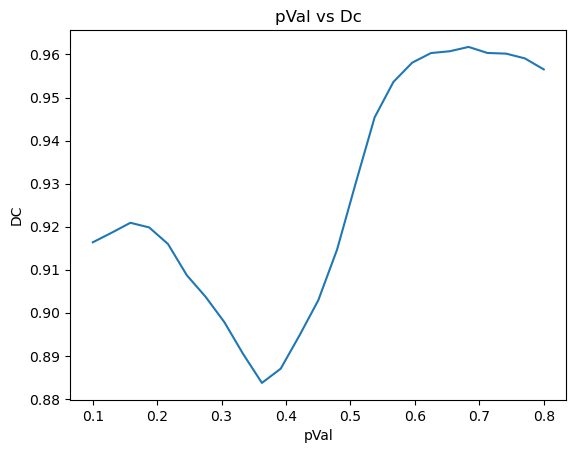

The highest IoU is: 0.9617581943723974
The corresponding pVal is: 0.6833333333333333


In [33]:
plt.plot(pVal, allDc)
plt.title('pVal vs Dc')  # Title of the plot
plt.xlabel('pVal')  # Label for the x axis
plt.ylabel('DC')  # Label for the y axis
plt.show()  # Display the plot
max_index = np.argmax(allDc)

# Retrieve the highest IoU value
highest_Dc = allDc[max_index]

# Retrieve the corresponding pVal
corresponding_pVal = pVal[max_index]

print("The highest IoU is:", highest_Dc)
print("The corresponding pVal is:", corresponding_pVal)

In [39]:
import numpy as np

# Example array ds
ds = np.array([10, 20, 30, 40, 50])

# Calculate min and max
min_val = np.min(ds)
max_val = np.max(ds)

ds = np.min(ds) + 0.25*(np.max(ds)-np.min(ds)) #Treshold 25% dari min. 

# Calculate 25% of the way from min to max
value_at_25_percent = min_val + 0.25 * (max_val - min_val)

print("Value at 25% from min to max:", value_at_25_percent)


Value at 25% from min to max: 20.0


In [17]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os

# Define your pVal array with the appropriate values
pVal=np.linspace(0.25, 0.8, 40)
images = []

# Load a TrueType font (.ttf)
# Make sure the path to the font file is correct. Here's an example using Arial.
# If you're on a system that doesn't have Arial, you may need to change this to a different font.
font_path = 'Arial.ttf'
font_size = 30  # You can adjust the size as needed

for m, p_Val in enumerate(pVal):
    npval = "{:.2f}".format(p_Val)  # Format value to 2 decimal places
    img_path = f'OUTOBJ3/ImageRecons{npval}.png'

    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
        continue
    
    img = Image.open(img_path).convert('RGBA')  # Convert to RGBA for consistent GIF output

    # Create a draw object to annotate the image
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font_path, font_size)
    text = f'pVal: {npval}'

    # Calculate text bounding box for accurate placement
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]

    # Position text at the bottom-right corner
    x = img.width - text_width - 10  # Adjust 10 pixels from the right edge
    y = img.height - text_height - 10  # Adjust 10 pixels from the bottom

    # Draw text on image
    draw.text((x, y), text, font=font, fill='black')

    images.append(img)

if images:
    gif_path = 'OUTOBJ3/my_gif.gif'
    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],  # Ensure images are appended correctly
        optimize=False,
        duration=100,
        loop=0,
        format='GIF'
    )
    print(f"GIF created successfully at: {gif_path}")
else:
    print("No images loaded, GIF not created.")


GIF created successfully at: OUTOBJ3/my_gif.gif


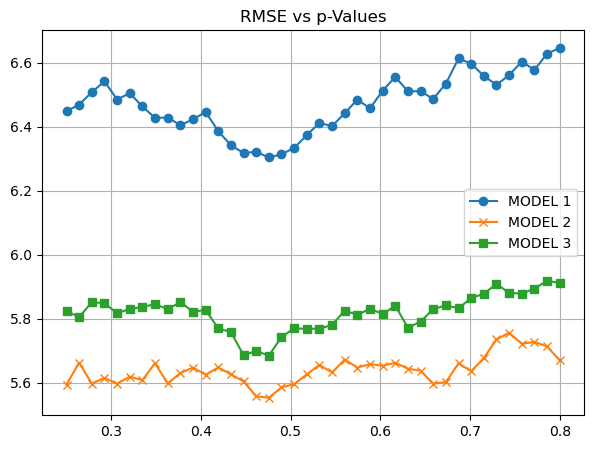

Model 1 RMSE: 6.304341 The corresponding pVal is: 0.47564102564102567
Model 2 RMSE: 5.553072 The corresponding pVal is: 0.47564102564102567
Model 3 RMSE: 5.684761 The corresponding pVal is: 0.47564102564102567


In [11]:
rmse1 = pd.read_csv('RMSE1.csv', header=None).squeeze() 
rmse2 = pd.read_csv('RMSE2.csv', header=None).squeeze()
rmse3 = pd.read_csv('RMSE3.csv', header=None).squeeze()
pVal=np.linspace(0.25, 0.8, 40)
plt.figure(figsize=(7, 5))  # Set the figure size
plt.plot(pVal, rmse1, label='MODEL 1', marker='o')  # Plot data for Model 1
plt.plot(pVal, rmse2, label='MODEL 2', marker='x')  # Plot data for Model 2
plt.plot(pVal, rmse3, label='MODEL 3', marker='s')  # Plot data for Model 3
plt.title('RMSE vs p-Values')  # Title of the plot
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()

print("Model 1 RMSE:", rmse1[np.argmin(rmse1)],"The corresponding pVal is:", pVal[np.argmin(rmse1)] )
print("Model 2 RMSE:", rmse2[np.argmin(rmse2)],"The corresponding pVal is:", pVal[np.argmin(rmse2)] )
print("Model 3 RMSE:", rmse3[np.argmin(rmse3)],"The corresponding pVal is:", pVal[np.argmin(rmse3)] )

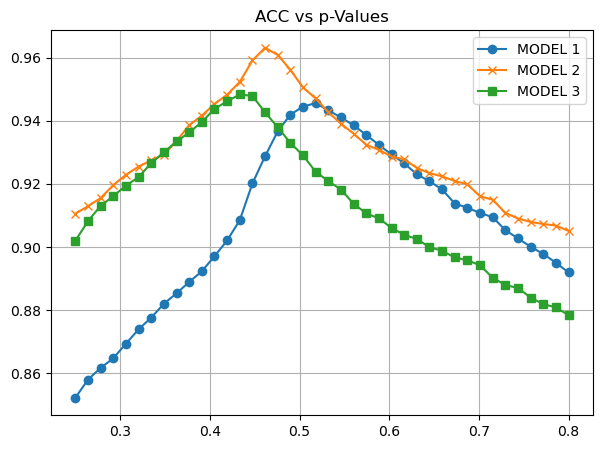

Model 1 Acc: 0.945589 The corresponding pVal is: 0.517948717948718
Model 2 Acc: 0.963134 The corresponding pVal is: 0.46153846153846156
Model 3 Acc: 0.952334 The corresponding pVal is: 0.43333333333333335


In [8]:
acc1 = pd.read_csv('ACC1.csv', header=None).squeeze() 
acc2 = pd.read_csv('ACC2.csv', header=None).squeeze()
acc3 = pd.read_csv('ACC3.csv', header=None).squeeze()
pVal=np.linspace(0.25, 0.8, 40)
plt.figure(figsize=(7, 5))  # Set the figure size
plt.plot(pVal, acc1, label='MODEL 1', marker='o')  # Plot data for Model 1
plt.plot(pVal, acc2, label='MODEL 2', marker='x')  # Plot data for Model 2
plt.plot(pVal, acc3, label='MODEL 3', marker='s')  # Plot data for Model 3
plt.title('ACC vs p-Values')  # Title of the plot
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()

print("Model 1 Acc:", acc1[np.argmax(acc1)],"The corresponding pVal is:", pVal[np.argmax(acc1)] )
print("Model 2 Acc:", acc2[np.argmax(acc2)],"The corresponding pVal is:", pVal[np.argmax(acc2)] )
print("Model 3 Acc:", acc2[np.argmax(acc3)],"The corresponding pVal is:", pVal[np.argmax(acc3)] )

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

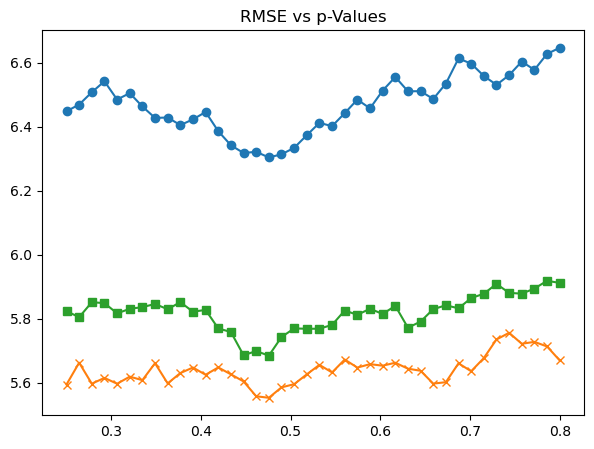